# Setup

Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import numba
import pandas as pd
import scipy.stats as stats
from povar import *
import time
import itertools

In [3]:
np.random.seed(63)

In [4]:
COLORS = list(colors.TABLEAU_COLORS.keys())
MARKERS = ["o", "s", "^", "P", "*"]

Default values

In [5]:
N0 = 1
T0 = 10000
D0 = 5
sigma0 = 1.0
omega0 = 0.1

In [6]:
default_params = r"""\begin{equation*} \begin{cases} \begin{aligned}"""
default_params += r"""T & = {} \\ D & = {} \\ \sigma & = {} \\ \omega & = {}""".format(
    T0, D0, sigma0, omega0)
default_params += r"""\end{aligned} \end{cases} \end{equation*}"""
with open("plots/sim/default_params.tex", "w") as file:
    file.write(default_params)

In [7]:
p_values = [0.125, 0.25, 0.5, 1.]

Unit test

In [8]:
theta = random_theta(D=50, s=5)

In [9]:
var = VAR(theta, sigma0)
sampler = IndependentSampler(0.5)
observer = Observer(omega0)

povar = POVAR(var, sampler, observer)

In [10]:
Z = povar.simulate(N0, T0)

In [11]:
povar.estimate_theta(Z, lambda0_range=np.logspace(-4, 0, 10), n_jobs=1, show_progress=True)
povar.estimate_theta(Z, lambda0_range=np.logspace(-4, 0, 10), n_jobs=5, show_progress=True);

Estimating theta:   0%|          | 0/50 [00:00<?, ?it/s]

Academic license - for non-commercial use only - expires 2021-07-20
Using license file /home/guillaume/gurobi.lic


Estimating theta:   0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
povar.estimate_theta(Z, h0=0, target_density=0.1, n_jobs=1);

In [13]:
povar.estimate_theta(Z, h0=0, target_density=0.1, n_jobs=5);

In [14]:
theta_hat_dense0  = povar.estimate_theta(Z, h0=0, target_density=1)
theta_hat_dense1 = povar.estimate_theta(Z, h0=1, target_density=1)

In [15]:
theta_hat_sparse0  = povar.estimate_theta(Z, h0=0, target_density=0.1)
theta_hat_sparse1 = povar.estimate_theta(Z, h0=1, target_density=0.1)

In [16]:
error_dense0 = np.linalg.norm(theta - theta_hat_dense0, 1)
error_dense1 = np.linalg.norm(theta - theta_hat_dense1, 1)
error_sparse0 = np.linalg.norm(theta - theta_hat_sparse0, 1)
error_sparse1 = np.linalg.norm(theta - theta_hat_sparse1, 1)

In [17]:
error_dense0, error_dense1, error_sparse0, error_sparse1

(1.071216452969164, 293.5303840840627, 0.26301507935748597, 1.1422545234834633)

# Parameter influence

In [18]:
def error(
    N=N0, T=T0, D=D0,
    s=None, target_density=None,
    sampling_scheme="indep",
    p=1, a=None, b=None,
    sigma=sigma0, omega=omega0, target_omega=None,
    h0=0,
    n_jobs=5
):
    if s is None:
        s = D
    if target_density is None:
        target_density = s/D
    
    if sampling_scheme == "indep":
        sampler = IndependentSampler(p)
    elif sampling_scheme == "fixed-size-rep":
        sampler = FixedSizeSampler(p, replace=True, time_indep=True)
    elif sampling_scheme == "markov":
        sampler = MarkovSampler(a=a, b=b)
        
    if target_omega is None:
        target_omega = omega

    theta = random_theta(D, s, norm=0.5)

    var = VAR(theta, sigma)
    observer = Observer(omega)
    povar = POVAR(var, sampler, observer)

    Z = povar.simulate(N, T)
    
    target_observer = Observer(target_omega)
    povar.observer = target_observer
    
    theta_hat = povar.estimate_theta(Z, h0=h0, target_density=target_density, n_jobs=n_jobs)
    error = np.linalg.norm(theta - theta_hat, np.inf)

    return error

## Influence of $T$

In [19]:
T_values = np.logspace(start=2, stop=5, num=100).astype(int)

In [20]:
T_errors = {}
for p in p_values:
    T_errors[p] = []
    for T in tqdm(T_values, desc="Testing influence of T for p={}".format(p)):
        T_errors[p].append(error(T=T, p=p))

Testing influence of T for p=0.125:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of T for p=0.25:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of T for p=0.5:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of T for p=1.0:   0%|          | 0/100 [00:00<?, ?it/s]

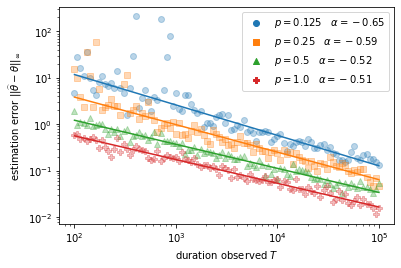

In [21]:
plt.close()
plt.xscale("log")
plt.yscale("log")
for (k, p) in enumerate(p_values):
    res = stats.siegelslopes(np.log(T_errors[p]), np.log(T_values))
    slope, intercept = res[0], res[1]
    T_lims = np.array([T_values[0], T_values[-1]])
    plt.plot(
        T_lims, np.exp(slope*np.log(T_lims) + intercept), 
        color=COLORS[k]
    )
    plt.scatter(
        T_values, T_errors[p],
        color=COLORS[k], marker=MARKERS[k], alpha=0.3,
        label="$p={}$   $\\alpha={}$".format(p, round(slope, ndigits=2)),
    )
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("duration observed $T$")
plt.ylabel("estimation error $|| \\widehat{\\theta} - \\theta ||_{\\infty}$")
plt.savefig("plots/sim/influence_T.pdf")
plt.show()

## Influence of $D$

In [22]:
D_values = np.logspace(start=np.log10(5), stop=np.log10(200), num=100).astype(int)

In [23]:
D_errors = {}
for p in p_values:
    D_errors[p] = []
    for D in tqdm(D_values, desc="Testing influence of D for p={}".format(p)):
        D_errors[p].append(error(D=D, p=p))

Testing influence of D for p=0.125:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of D for p=0.25:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of D for p=0.5:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of D for p=1.0:   0%|          | 0/100 [00:00<?, ?it/s]

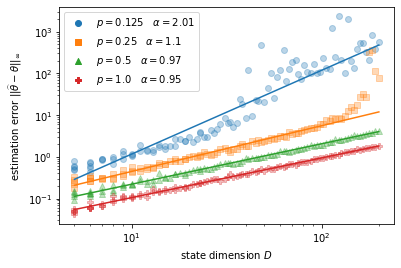

In [24]:
plt.close()
plt.xscale("log")
plt.yscale("log")
for (k, p) in enumerate(p_values):
    res = stats.siegelslopes(np.log(D_errors[p]), np.log(D_values))
    slope, intercept = res[0], res[1]
    D_lims = np.array([D_values[0], D_values[-1]])
    plt.plot(
        D_lims, np.exp(slope*np.log(D_lims) + intercept),
        color=COLORS[k]
    )
    plt.scatter(
        D_values, D_errors[p],
        color=COLORS[k], marker=MARKERS[k], alpha=0.3, 
        label="$p={}$   $\\alpha={}$".format(p, round(slope, ndigits=2)),
    )
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("state dimension $D$")
plt.ylabel("estimation error $|| \\widehat{\\theta} - \\theta ||_{\\infty}$")
plt.savefig("plots/sim/influence_D.pdf")
plt.show()

## Influence of $\omega$

In [25]:
omega_values = np.logspace(-1.5, 1.5, 100)

In [26]:
omega_errors = {}
for p in p_values:
    omega_errors[p] = []
    for omega in tqdm(omega_values, desc="Testing influence of omega for p={}".format(p)):
        omega_errors[p].append(error(omega=omega, p=p))

Testing influence of omega for p=0.125:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of omega for p=0.25:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of omega for p=0.5:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of omega for p=1.0:   0%|          | 0/100 [00:00<?, ?it/s]

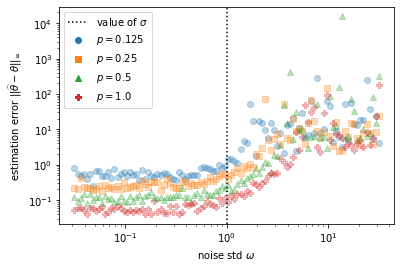

In [27]:
plt.close()
plt.xscale("log")
plt.yscale("log")
for (k, p) in enumerate(p_values):
    plt.scatter(
        omega_values, omega_errors[p],
        color=COLORS[k], marker=MARKERS[k], alpha=0.3,
        label="$p={}$".format(p)
    )
plt.axvline(x=sigma0, linestyle="dotted", color="k", label="value of $\sigma$")
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("noise std $\omega$")
plt.ylabel("estimation error $|| \\widehat{\\theta} - \\theta ||_{\\infty}$")
plt.savefig("plots/sim/influence_omega.pdf")
plt.show()

## Influence of misspecified $\omega$

In [28]:
target_omega_values = np.logspace(-1, 0, 100)

In [29]:
target_omega_errors = {}
for p in p_values:
    target_omega_errors[p] = []
    for target_omega in tqdm(target_omega_values, desc="Testing influence of target_omega for p={}".format(p)):
        target_omega_errors[p].append(error(omega=0.5, target_omega=target_omega, p=p))

Testing influence of target_omega for p=0.125:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of target_omega for p=0.25:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of target_omega for p=0.5:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of target_omega for p=1.0:   0%|          | 0/100 [00:00<?, ?it/s]

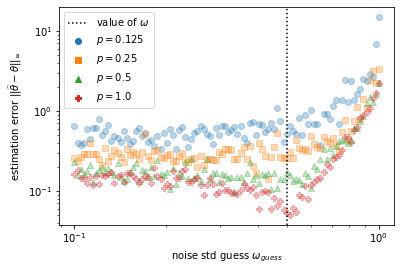

In [30]:
plt.close()
plt.xscale("log")
plt.yscale("log")
for (k, p) in enumerate(p_values):
    plt.scatter(
        target_omega_values, target_omega_errors[p],
        color=COLORS[k], marker=MARKERS[k], alpha=0.3,
        label="$p={}$".format(p)
    )
plt.axvline(x=0.5, linestyle="dotted", color="k", label="value of $\omega$")
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("noise std guess $\omega_{guess}$")
plt.ylabel("estimation error $|| \\widehat{\\theta} - \\theta ||_{\\infty}$")
plt.savefig("plots/sim/influence_target_omega.pdf")
plt.show()

## Influence of $p$ for non-Markov sampling schemes

In [31]:
D_for_p = 20
p_values_many = np.logspace(np.log10(2/D_for_p), 0, 100)

In [32]:
sampling_schemes = ["indep", "fixed-size-rep"]

In [33]:
p_errors = {}
for sampling_scheme in sampling_schemes:
    p_errors[sampling_scheme] = []
    for p in tqdm(p_values_many, desc="Testing influence of p for {} sampling".format(sampling_scheme)):
        p_errors[sampling_scheme].append(
            error(D=D_for_p, sampling_scheme=sampling_scheme, p=p, omega=0))

Testing influence of p for indep sampling:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of p for fixed-size-rep sampling:   0%|          | 0/100 [00:00<?, ?it/s]

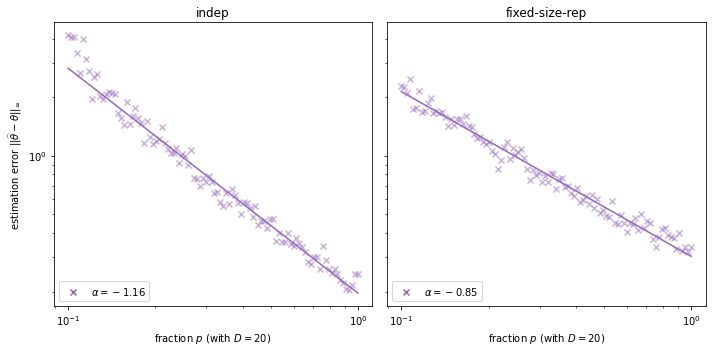

In [34]:
plt.close()
fig, ax = plt.subplots(
    1, len(sampling_schemes),
    sharey=True, sharex=True,
    figsize=(10, 5)
)
for (k, sampling_scheme) in enumerate(sampling_schemes):
    ax[k].set_xscale("log")
    ax[k].set_yscale("log")

    res = stats.siegelslopes(np.log(p_errors[sampling_scheme]), np.log(p_values_many))
    slope, intercept = res[0], res[1]
    ax[k].scatter(
        p_values_many, p_errors[sampling_scheme],
        color="tab:purple", marker="x", alpha=0.5,
        label="$\\alpha={}$".format(round(slope, ndigits=2)),
    )
    p_lims = np.array([p_values_many[0], p_values_many[-1]])
    ax[k].plot(
        p_lims, np.exp(slope*np.log(p_lims) + intercept),
        color="tab:purple"
    )
    leg = ax[k].legend(loc="lower left")
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax[k].set_title(sampling_scheme)
    ax[k].set_xlabel("fraction $p$ (with $D = {}$)".format(D_for_p))
    if k == 0:
        ax[k].set_ylabel("estimation error $|| \\widehat{\\theta} - \\theta ||_{\\infty}$")

plt.tight_layout()    
plt.savefig("plots/sim/influence_p.pdf")
plt.show()

## Influence of $p$ for Markov sampling schemes

In [35]:
b_values = [1-0.2, 1-0.4, 1-0.8]

In [36]:
p_values_ab = {}
p_errors_ab = {}
for b in b_values:
    p_values_ab[b] = []
    p_errors_ab[b] = []
    for p in tqdm(p_values_many, desc="Testing influence of p for b={}".format(b)):
        a = b/(1-p)-b
        if a < 1 and b < 1:
            p_values_ab[b].append(p)
            p_errors_ab[b].append(error(D=D_for_p, sampling_scheme="markov", a=a, b=b))

Testing influence of p for b=0.8:   0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-36-772f64823cd2>:7: RuntimeWarning: divide by zero encountered in double_scalars
  a = b/(1-p)-b


Testing influence of p for b=0.6:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of p for b=0.19999999999999996:   0%|          | 0/100 [00:00<?, ?it/s]

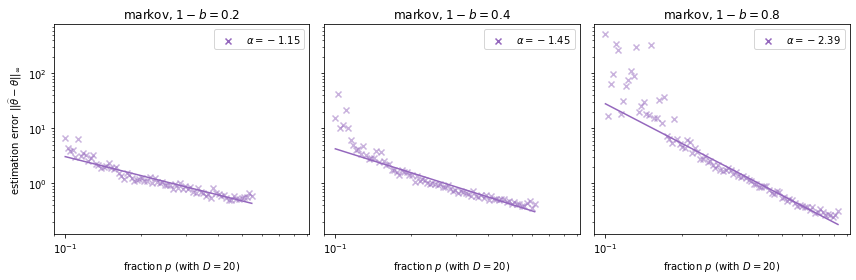

In [37]:
plt.close()
fig, ax = plt.subplots(
    1, len(b_values),
    sharey=True, sharex=True,
    figsize=(12, 4)    
)
for (k, b) in enumerate(b_values):
    ax[k].set_xscale("log")
    ax[k].set_yscale("log")

    res = stats.siegelslopes(np.log(p_errors_ab[b]), np.log(p_values_ab[b]))
    slope, intercept = res[0], res[1]
    ax[k].scatter(
        p_values_ab[b], p_errors_ab[b],
        color="tab:purple", marker="x", alpha=0.5,
        label="$\\alpha={}$".format(round(slope, ndigits=2)),
    )
    p_lims = np.array([p_values_ab[b][0], p_values_ab[b][-1]])
    ax[k].plot(
        p_lims, np.exp(slope*np.log(p_lims) + intercept),
        color="tab:purple"
    )
    leg = ax[k].legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax[k].set_title("markov, $1-b={}$".format(round(1-b, ndigits=2)))
    ax[k].set_xlabel("fraction $p$ (with $D = {}$)".format(D_for_p))
    if k == 0:
        ax[k].set_ylabel("estimation error $|| \\widehat{\\theta} - \\theta ||_{\\infty}$")
    
plt.tight_layout()
plt.savefig("plots/sim/influence_p_markov.pdf")
plt.show()

## Influence of $(p, q)$ for Markov sampling

In [40]:
K = 100
a_values = np.logspace(-1.5, -0.5, K+1)[:-1]
b_values = 1-np.logspace(-1.5, -0.5, K+1)[:-1]

In [41]:
ab_errors = {}
for (a, b) in tqdm(list(itertools.product(a_values, b_values))):
    ab_errors[(a, b)] = error(D=D_for_p, sampling_scheme="markov", a=a, b=b)

  0%|          | 0/10000 [00:00<?, ?it/s]

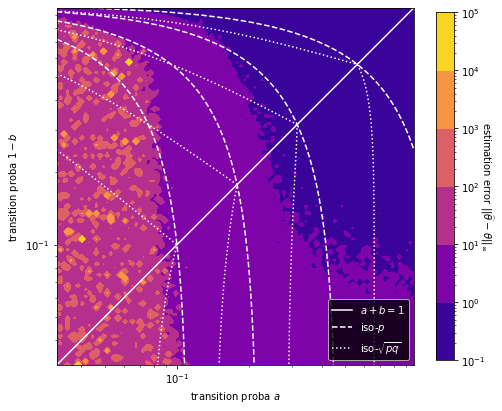

In [42]:
A, MB = np.meshgrid(a_values, 1-b_values)
E, P, Q = np.empty((K, K)), np.empty((K, K)), np.empty((K, K))
for i in range(K):
    for j in range(K):
        a, b = A[i, j], 1-MB[i, j]
        p = a/(a+b)
        q = p + (1-p)*np.abs(1-a-b)
        e = ab_errors[(a, b)]
        E[i, j], P[i, j], Q[i, j] = e, p, q

plt.close()
plt.figure(figsize=(8, 8))
plt.xscale("log")
plt.yscale("log")

contour_err = plt.contourf(
    A, MB, E,
    norm=colors.LogNorm(), cmap="plasma"
)
contour_p = plt.contour(
    A, MB, P,
    colors="w", linestyles="dashed",
    levels=np.logspace(-1, 0, 5)
)
contour_pq = plt.contour(
    A, MB, np.sqrt(P*Q),
    colors="w", linestyles="dotted",
    levels=np.logspace(-1, 0, 5)
)

cbar = plt.colorbar(contour_err, shrink=0.8)
cbar.set_label("estimation error $|| \\widehat{\\theta} - \\theta ||_{\\infty}$", rotation=270, labelpad=10)
# plt.clabel(contour_p, fmt=" $p=%1.3f$ ")
# plt.clabel(contour_pq, fmt=" $\\sqrt{pq}=%1.3f$ ")
contour_p.collections[0].set_label("iso-$p$")
contour_pq.collections[0].set_label("iso-$\\sqrt{pq}$")
plt.plot(
    [min(a_values), max(a_values)],
    [1-max(b_values), 1-min(b_values)],
    color="w", linestyle="solid", label="$a+b=1$"
)
legend = plt.legend(loc="lower right", facecolor="black")
plt.setp(legend.get_texts(), color='w')
plt.xlabel("transition proba $a$")
plt.ylabel("transition proba $1-b$")
plt.axis("scaled")
plt.savefig("plots/sim/influence_pq_markov.pdf")
plt.show()

## Influence of $p$ for each $h_0$

In [46]:
h0_values = [0, 1, 2]
D_for_h0 = 2

In [47]:
p_errors_h = {}
for h0 in h0_values:
    p_errors_h[h0] = []
    for p in tqdm(p_values_many, desc="Testing influence of p for h0={}".format(h0)):
        p_errors_h[h0].append(error(D=D_for_h0, p=p, h0=h0))

Testing influence of p for h0=0:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of p for h0=1:   0%|          | 0/100 [00:00<?, ?it/s]

Testing influence of p for h0=2:   0%|          | 0/100 [00:00<?, ?it/s]

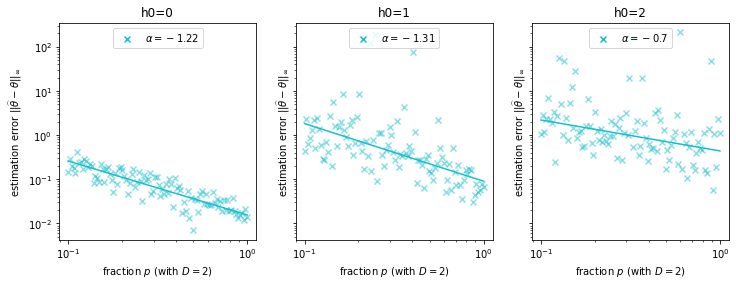

In [48]:
plt.close()
fig, ax = plt.subplots(
    1, len(h0_values),
    sharey=True, sharex=True,
    figsize=(12, 4)
)
for (k, h0) in enumerate(h0_values):
    ax[k].set_xscale("log")
    ax[k].set_yscale("log")

    res = stats.siegelslopes(np.log(p_errors_h[h0]), np.log(p_values_many))
    slope, intercept = res[0], res[1]
    ax[k].scatter(
        p_values_many, p_errors_h[h0],
        color="tab:cyan", marker="x", alpha=0.5,
        label="$\\alpha={}$".format(round(slope, ndigits=2)),
    )
    p_lims = np.array([p_values_many[0], p_values_many[-1]])
    ax[k].plot(
        p_lims, np.exp(slope*np.log(p_lims) + intercept),
        color="tab:cyan"
    )
    leg = ax[k].legend(loc="upper center")
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax[k].set_title("h0={}".format(h0))
    ax[k].set_xlabel("fraction $p$ (with $D={}$)".format(D_for_h0))
    ax[k].set_ylabel("estimation error $|| \\widehat{\\theta} - \\theta ||_{\\infty}$")
plt.savefig("plots/sim/influence_h.pdf")
plt.show()

## Influence of $s$

In [58]:
s_values = np.arange(5, 50)
D_for_s = 100

In [59]:
s_errors = {}
for p in p_values[1:]:
    s_errors[p] = [
        error(D=D_for_s, s=s, p=p)
        for s in tqdm(s_values, desc="Testing influence of s for p={}".format(p))
    ]

Testing influence of s for p=0.25:   0%|          | 0/45 [00:00<?, ?it/s]

Testing influence of s for p=0.5:   0%|          | 0/45 [00:00<?, ?it/s]

Testing influence of s for p=1.0:   0%|          | 0/45 [00:00<?, ?it/s]

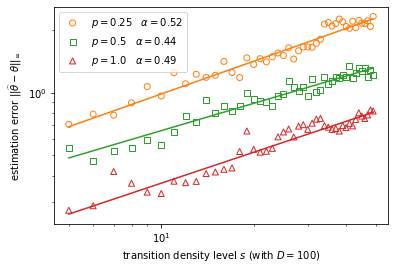

In [61]:
plt.close()
plt.xscale("log")
plt.yscale("log")
for (k, p) in enumerate(p_values[1:]):
    res = stats.siegelslopes(np.log(s_errors[p]), np.log(s_values))
    slope, intercept = res[0], res[1]
    s_lims = np.array([s_values[0], s_values[-1]])
    plt.plot(
        s_lims, np.exp(slope*np.log(s_lims) + intercept),
        color=COLORS[1:][k]
    )
    plt.scatter(
        s_values, s_errors[p],
        color=COLORS[1:][k], marker=MARKERS[k], alpha=1, facecolor="none",
        label="$p={}$   $\\alpha={}$".format(p, round(slope, ndigits=2)),
    )
leg = plt.legend(loc="upper left")
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("transition density level $s$ (with $D = {}$)".format(D_for_s))
plt.ylabel("estimation error $|| \\widehat{\\theta} - \\theta ||_{\\infty}$")
plt.savefig("plots/sim/influence_s.pdf")
plt.show()

## Influence of $D$ vs $s$

In [62]:
D_values_for_s = np.arange(5, 100, 2)
real_s = 5

In [63]:
Ds_errors_dense = {}
Ds_errors_sparse = {}
for p in p_values[1:]:
    Ds_errors_dense[p] = [
        error(D=D, s=real_s, target_density=1, p=p)
        for D in tqdm(D_values_for_s, desc="Testing influence of D wrt s for p={} (dense)".format(p))
    ]
    Ds_errors_sparse[p] = [
        error(D=D, s=real_s, target_density=real_s/D, p=p)
        for D in tqdm(D_values_for_s, desc="Testing influence of D wrt s for p={} (sparse)".format(p))
    ]

Testing influence of D wrt s for p=0.25 (dense):   0%|          | 0/48 [00:00<?, ?it/s]

Testing influence of D wrt s for p=0.25 (sparse):   0%|          | 0/48 [00:00<?, ?it/s]

Testing influence of D wrt s for p=0.5 (dense):   0%|          | 0/48 [00:00<?, ?it/s]

Testing influence of D wrt s for p=0.5 (sparse):   0%|          | 0/48 [00:00<?, ?it/s]

Testing influence of D wrt s for p=1.0 (dense):   0%|          | 0/48 [00:00<?, ?it/s]

Testing influence of D wrt s for p=1.0 (sparse):   0%|          | 0/48 [00:00<?, ?it/s]

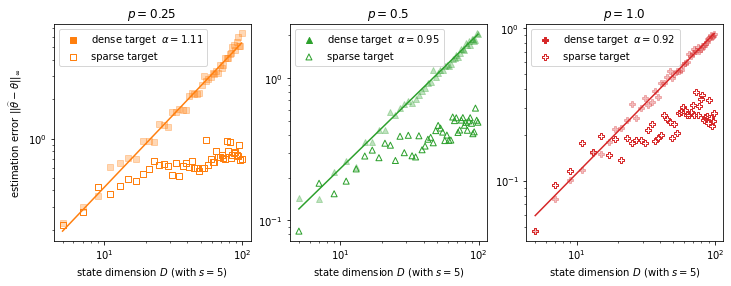

In [64]:
plt.close()
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=False, sharex=True)
for (k, p) in enumerate(p_values[1:]):
    ax[k].set_xscale("log")
    ax[k].set_yscale("log")

     # Dense estimation
    res = stats.siegelslopes(np.log(Ds_errors_dense[p]), np.log(D_values_for_s))
    slope, intercept = res[0], res[1]
    D_lims = np.array([D_values_for_s[0], D_values_for_s[-1]])
    ax[k].scatter(
        D_values_for_s, Ds_errors_dense[p],
        color=COLORS[1:][k], marker=MARKERS[1:][k], alpha=0.3,
        label="dense target  $\\alpha={}$".format(round(slope, ndigits=2)),
    )
    ax[k].plot(
        D_lims, np.exp(slope*np.log(D_lims) + intercept),
        color=COLORS[1:][k]
    )

    # Sparse estimation
    res = stats.siegelslopes(np.log(Ds_errors_sparse[p]), np.log(D_values_for_s))
    slope, intercept = res[0], res[1]
    D_lims = np.array([D_values_for_s[0], D_values_for_s[-1]])
    ax[k].scatter(
        D_values_for_s, Ds_errors_sparse[p],
        color=COLORS[1:][k], marker=MARKERS[1:][k], alpha=1, facecolor="none",
        label="sparse target"
    )
#     ax[k].plot(
#         D_lims, np.exp(slope*np.log(D_lims) + intercept),
#         color=COLORS[1:][k], linestyle="dotted",
#     )

    leg = ax[k].legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax[k].set_xlabel("state dimension $D$ (with $s={}$)".format(real_s))
    ax[k].set_title("$p={}$".format(p))
    if k == 0:
        ax[k].set_ylabel("estimation error $|| \\widehat{\\theta} - \\theta ||_{\\infty}$")
plt.savefig("plots/sim/influence_Ds.pdf")
plt.show()